# Calculation of the static constant for our unloaded mini-Arm

In [35]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt

dataTable = pd.read_csv('FRC_20230204_201513.csv')#Enter log file from Quasistatic
dataTable['Time'] = dataTable['Timestamp'].round(2)
COI=['NT:/SmartDashboard/Arm Angle',
    'NT:/SmartDashboard/Arm Rate',
    'NT:/SmartDashboard/Arm Volts']

AngleData = dataTable.loc[dataTable['Name']==COI[0],['Time','Value']]
RateData = dataTable.loc[dataTable['Name']==COI[1],['Time','Value']]
VoltData = dataTable.loc[dataTable['Name']==COI[2],['Time','Value']]
DataOI = VoltData.merge(AngleData.merge(RateData, on='Time', suffixes= ['_Angle','_Rate']), how='outer', on='Time')

DataOI.loc[:,'Value_Angle'] = DataOI['Value_Angle'].fillna(method='ffill').astype(float)
DataOI.loc[:,'Value_Angle'] = DataOI["Value_Angle"] + 2.5
DataOI.loc[:,'Value_Rate'] = DataOI['Value_Rate'].fillna(method='ffill').astype(float)
DataOI.loc[:,'Value'] = DataOI['Value'].fillna(method='ffill').astype(float)
DataOI = DataOI.sort_values('Time')

Ks = 0.656


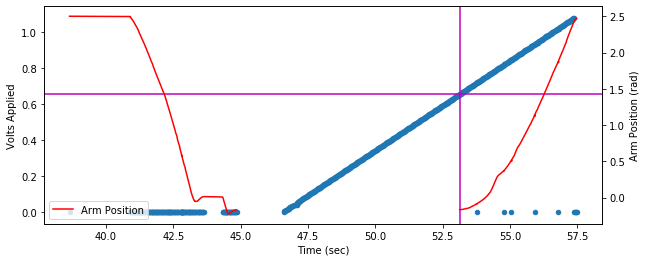

In [36]:
ax = DataOI.plot.scatter(x='Time',y='Value', figsize=(10,4))
ax2 = ax.twinx()
DataOI.plot(x='Time',y='Value_Angle', ax=ax2, color = 'r', label = 'Arm Position')
AngleMoveTime = DataOI.loc[(DataOI['Time']>50) & (DataOI['Value_Angle'] > -1),'Time'].min()
ax.axvline(AngleMoveTime, c='m')
Ks = DataOI.loc[DataOI['Time']==AngleMoveTime,'Value'].iloc[0]
ax.axhline(Ks, c='m')
ax.set_ylabel("Volts Applied")
ax2.set_ylabel("Arm Position (rad)")
ax.set_xlabel('Time (sec)')
print("Ks = {:.3f}".format(Ks))
plt.show()



Analysis of these plots demonstrates that the voltage required to move the apparatus at all is 0.656 volts. This will be the K$_s$ values in our feedforward calculations.

## Calculation of K$_g$ and K$_v$ from QuasiStatic Analysis of unloaded arm.

These data were collected from a range of -0.77 radians (-44°) to 4.18 radians (240°), with 0 defined as the arm in a horizontal position. From the minimal value a 0.9 V step was applied to provide a constant drive to the motor.

In [37]:
dataTable = pd.read_csv('FRC_20230204_205449.csv')
dataTable['Time'] = dataTable['Timestamp'].round(2)
COI=['NT:/SmartDashboard/Arm Angle',
    'NT:/SmartDashboard/Arm Rate',
    'NT:/SmartDashboard/Arm Volts']

AngleData = dataTable.loc[dataTable['Name']==COI[0],['Time','Value']]
RateData = dataTable.loc[dataTable['Name']==COI[1],['Time','Value']]
VoltData = dataTable.loc[dataTable['Name']==COI[2],['Time','Value']]
DataOI = VoltData.merge(AngleData.merge(RateData, on='Time', suffixes= ['_Angle','_Rate']), how='outer', on='Time')

DataOI.loc[:,'Value_Angle'] = DataOI['Value_Angle'].fillna(method='ffill').astype(float)
#DataOI.loc[:,'Value_Angle'] = DataOI["Value_Angle"] + 2.5
DataOI.loc[:,'Value_Rate'] = DataOI['Value_Rate'].fillna(method='ffill').astype(float)
DataOI.loc[:,'Value'] = DataOI['Value'].fillna(method='ffill').astype(float)
DataOI = DataOI.loc[DataOI['Time']> 51,].sort_values('Time')
DataOI = DataOI.iloc[1:,:]

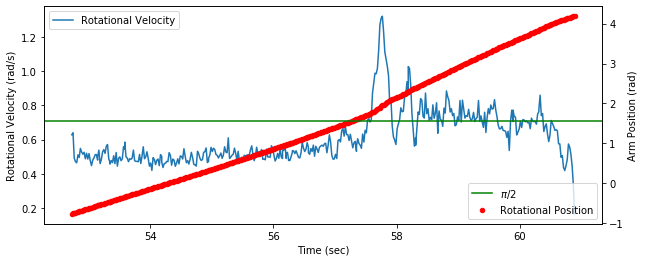

In [38]:
ax = DataOI.plot(x='Time',y='Value_Rate', figsize=(10,4), label = 'Rotational Velocity')
ax.legend(loc='upper left')
ax2 = ax.twinx()
ax2.axhline(math.pi/2, c= 'green', label = "$\pi$/2")
DataOI.plot.scatter(x='Time',y='Value_Angle', ax=ax2, color = 'r',label = 'Rotational Position')
ax2.legend(loc='lower right')
ax2.set_ylabel('Arm Position (rad)')
ax.set_ylabel('Rotational Velocity (rad/s)')
ax.set_xlabel('Time (sec)')
plt.show()

The equation describing the voltages required to move an arm is: 

V = K$_s$ + K$_g$cos($\theta$) + K$_v \dot{\theta}$ + K$_a \ddot{\theta}$ 

Where $\dot{\theta}$ is rotational velocity and $\ddot{\theta}$ is rotational acceleration.
In our example acceleration is essentially 0 ($\ddot{\theta} = 0$), thus this equation can be simplified to:

V = K$_s$ + K$_g$cos($\theta$) + K$_v \dot{\theta}$

Using some of our known constants we can rearrange this to get:

$\dot{\theta}$ = $\frac{-K_g}{K_v} cos(\theta) + \frac{V - K_s}{K_v}$

Therefore the angular velocity ($\dot{\theta}$) vs. the cos($\theta$) should be linear. To assess this we create this plot here.

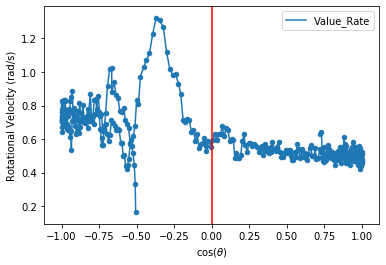

In [39]:
DataOI['cos_Theta'] = np.cos(DataOI['Value_Angle'])
ax = DataOI.plot(x='cos_Theta', y= 'Value_Rate')
DataOI.plot.scatter(x='cos_Theta', y= 'Value_Rate', ax = ax)
ax.axvline(0, color = 'red')
ax.set_ylabel("Rotational Velocity (rad/s)")
ax.set_xlabel(r"cos($\theta$)")
plt.show()

The linearity of this requires a bit of imagination. This protocol starts with a cos($\theta$) of about 0.75, which increase to 1 then begins moving back towards a cos($\theta$) of 0, when the arm is vertical. Shortly after this vertical position, there is a large deviation from the expected linear increase. This is likely to to the mechanism slipping allowing the arm to skip forward. Notabley, this is followed by a period of slower rotational movement as the mechanism catches again. Using all of the data we get the following:

The slope of the line of best fit is -0.13 with an intercept of 0.62.


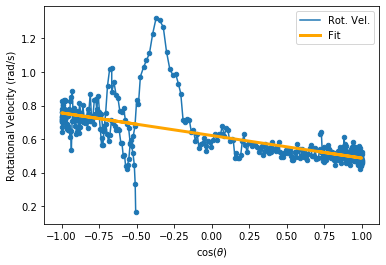

In [40]:
import scipy.stats
lm = scipy.stats.linregress(DataOI['cos_Theta'].to_numpy(), DataOI['Value_Rate'].to_numpy())
slope = lm.slope
intercept = lm.intercept
print('The slope of the line of best fit is {:.2f} with an intercept of {:.2f}.'.format(slope,intercept))
DataOI['Fit'] = slope * DataOI['cos_Theta'] + intercept

DataOI['cos_Theta'] = np.cos(DataOI['Value_Angle'])
ax = DataOI.plot(x='cos_Theta', y= 'Value_Rate', label = 'Rot. Vel.')
DataOI.plot.scatter(x='cos_Theta', y= 'Value_Rate', ax = ax)
DataOI.plot(x='cos_Theta', y= 'Fit', ax = ax, color = 'orange', lw=3)
ax.set_ylabel('Rotational Velocity (rad/s)')
ax.set_xlabel(r"cos($\theta$)")
plt.show()

Based on our prior derivation the slope of this line is:

slope = $\frac{-K_g}{K_v}$

and the intercept is:

intercept = $\frac{V - K_s}{K_v}$

Given that V = 0.9 V, K$_s$ = 0.656; K$_v$ = $\frac{V - K_s}{intercept} = \frac{0.9 V - 0.656 V}{0.62 rad/s} = 0.151 V \cdot sec/rad$

We can then use this calculated value of K$_v$ to determine K$_g$, by K$_g$ = -slope * K$_v$ = 0.13 rad/s * 0.151 V$\cdot$sec/rad = 0.0197 V.

# Weighted arm calculations

The imbalance between the frictional component K$_v$ and the gravitational component K$_g$ likely results from the very light nature of the miniArm construct. To explore the consequences of adding weight to the end of the arm, our mini arm was fit with bearings secured to the end of the arm. Similar experimental paradigms were used to characterize this loaded model. We begin by calculating K$_s$.

## Calculation of K$_s$ in weighted arm

In [33]:
dataTable = pd.read_csv('FRC_20230204_223954.csv')
dataTable['Time'] = dataTable['Timestamp'].round(2)
COI=['NT:/SmartDashboard/Arm Angle',
    'NT:/SmartDashboard/Arm Rate',
    'NT:/SmartDashboard/Arm Volts']

AngleData = dataTable.loc[dataTable['Name']==COI[0],['Time','Value']]
RateData = dataTable.loc[dataTable['Name']==COI[1],['Time','Value']]
VoltData = dataTable.loc[dataTable['Name']==COI[2],['Time','Value']]
DataOI = VoltData.merge(AngleData.merge(RateData, on='Time', suffixes= ['_Angle','_Rate']), how='outer', on='Time')

DataOI.loc[:,'Value_Angle'] = DataOI['Value_Angle'].fillna(method='ffill').astype(float)
DataOI.loc[:,'Value_Angle'] = DataOI["Value_Angle"] + 2.5
DataOI.loc[:,'Value_Rate'] = DataOI['Value_Rate'].fillna(method='ffill').astype(float)
DataOI.loc[:,'Value'] = DataOI['Value'].fillna(method='ffill').astype(float)
DataOI_static1 = DataOI.loc[DataOI['Time'].between(45,51),].sort_values('Time')
DataOI_static1 = DataOI_static1.iloc[1:,:]
DataOI_static2 = DataOI.loc[DataOI['Time'].between(80,85),].sort_values('Time')
DataOI_static2 = DataOI_static2.iloc[1:,:]


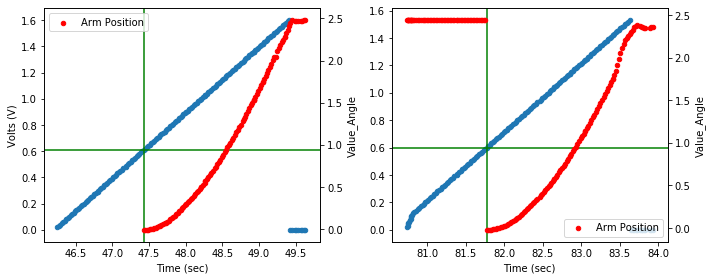

Average weighted Ks = 0.605V


In [34]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
DataOI_static1.plot.scatter(x='Time',y='Value', ax = axs[0])
ax2 = axs[0].twinx()
DataOI_static1.plot.scatter(x='Time',y='Value_Angle', ax=ax2, color = 'r', label = "Arm Position")
AngleMoveTime = DataOI_static1.loc[(DataOI_static1['Time']>47) & (DataOI_static1['Value_Angle'] > -1),'Time'].min()
Ks = DataOI_static1.loc[DataOI_static1['Time']==AngleMoveTime,'Value'].iloc[0]
axs[0].axvline(AngleMoveTime, color='green')
axs[0].axhline(Ks, color = 'green')
ax = DataOI_static2.plot.scatter(x='Time',y='Value', ax=axs[1])
ax2 = axs[1].twinx()
DataOI_static2.plot.scatter(x='Time',y='Value_Angle', ax=ax2, color = 'r', label = "Arm Position")
AngleMoveTime = DataOI_static2.loc[(DataOI_static2['Time']>81.76) &\
                                   (DataOI_static2['Value_Angle'] > -1) &\
                                   (DataOI_static2['Value_Angle'] <1 ),'Time'].min()
axs[1].axvline(AngleMoveTime, color='g')
Ks_2 = DataOI_static2.loc[DataOI_static2['Time']==AngleMoveTime,'Value'].iloc[0]
axs[1].axhline(Ks_2, color='g')

axs[0].set_ylabel("Volts (V)")
axs[1].set_ylabel("")
axs[0].set_xlabel("Time (sec)")
axs[1].set_xlabel("Time (sec)")
plt.tight_layout()
plt.show()

print("Average weighted Ks = {:.3f}V".format((Ks+Ks_2)/2))



These plots demonstrate that the K$_v$ for the loaded arm is sligtly lower than that for the unwieghted arm. This likely results from changes in the contribution of gravity. When making these measurements we placed the arm in a vertical position, this was done to limit the effects of graviety on the voltage required to begin moving the mechanism. However, it is a little difficult to completely isolate the effects of gravity if the arm was slightly off of vertical, the mass at the end of the arm will provide some torque which can reduce the voltage required to begin rotational movement. Overall the effect of loading the arm is relatively minor with a variation of only $\approx$ 50mV.

## Calculation of K$_g$ and K$_v$ from quasistatic Analysis of loaded arm.

As previously performed, the voltage was stepped to 0.9 V and the movement of the arm was measured. This was repeated several times and the resulting data combined for the following analysis.

In [31]:
qTimes = [[104,110],[129,135],[255,261],[278,283]]
qData = pd.DataFrame()
for idx, times in enumerate(qTimes):
    tmpData = DataOI.loc[DataOI['Time'].between(times[0],times[1]),]
    tmpData.insert(0,'RunID','Run_'+str(idx))
    qData = qData.append(tmpData)

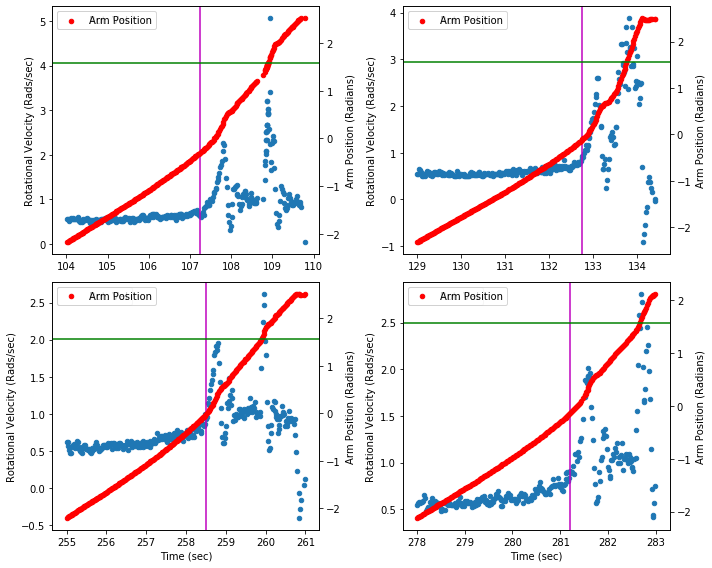

In [32]:
fig, axs = plt.subplots(2,2, figsize = (10,8))
plotmap = {0:[0,0],1:[0,1],2:[1,0],3:[1,1]}
cutoffs = {0:107.25, 1:132.75, 2:258.5, 3:281.2}
q_Data = pd.DataFrame()
for i in range(0,4):
    plotData = qData.loc[qData['RunID'] == 'Run_' + str(i),]
    plotLoc = plotmap[i]
    plotData.plot.scatter(x='Time', y = 'Value_Rate', ax= axs[plotLoc[0],plotLoc[1]],label = "Rot. Vel")
    ax2 = axs[plotLoc[0],plotLoc[1]].twinx()
    plotData.plot.scatter(x='Time', y= 'Value_Angle', ax= ax2, c='r', label = 'Arm Position')
    ax2.set_ylabel("Arm Position (Radians)")
    axs[plotLoc[0],plotLoc[1]].set_ylabel("Rotational Velocity (Rads/sec)")
    axs[plotLoc[0],plotLoc[1]].set_xlabel("Time (sec)")
    axs[plotLoc[0],plotLoc[1]].axvline(cutoffs[i], color = 'm')
    ax2.axhline(math.pi/2, c= 'green', label = "$\pi$/2")
    tmpData = plotData.loc[plotData['Time']< cutoffs[i],]
    q_Data = q_Data.append(tmpData)

axs[0,0].tick_params(axis='both', which='both',  labelbottom=True)
axs[0,1].tick_params(axis='both', which='both',  labelbottom=True)
plt.tight_layout()
plt.show()

These plots demonstrate that our mechanism was quite noisy as the arm approached a vertical orientation and during the descent. This was accompanyied/caused by slipping of the belt. To account for this we will perform that analysis on the portion of the plot where the mechanism was at work. This might create a bias, as we are only looking at values during the up swing of the arm. We will need to make sure that the mechanism does not slip when we characterize the real mechanism. Using this truncated dataset we will perform the analysis to determine the nature of the K$_v$ and K$_g$ in this system.

The slope of the line of best fit is 0.12 with an intercept of 0.57.
The slope of the best fit from the rising arm is -0.04 with an intercept of 0.53.


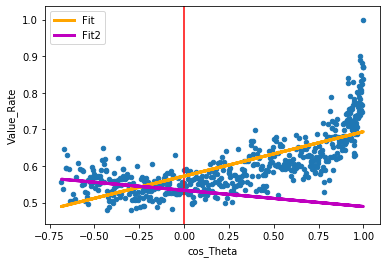

In [23]:
q_Data['cos_Theta'] = np.cos(q_Data['Value_Angle'])
ax = q_Data.plot.scatter(x='cos_Theta', y= 'Value_Rate')
#qData.plot.scatter(x='cos_Theta', y= 'Value_Rate', ax = ax)
ax.axvline(0, color = 'red')

lm = scipy.stats.linregress(q_Data['cos_Theta'].to_numpy(), q_Data['Value_Rate'].to_numpy())
slope = lm.slope
intercept = lm.intercept
q_Data['Fit'] = slope * q_Data['cos_Theta'] + intercept
q_Data.plot(x='cos_Theta', y= 'Fit', ax = ax, color = 'orange', lw=3)

q2_Data = q_Data.loc[q_Data['cos_Theta']<0,]
lm2 = scipy.stats.linregress(q2_Data['cos_Theta'].to_numpy(), q2_Data['Value_Rate'].to_numpy())
slope2 = lm2.slope
intercept2 = lm2.intercept
q_Data['Fit2'] = slope2 * q_Data['cos_Theta'] + intercept2
q_Data.plot(x='cos_Theta', y= 'Fit2', ax = ax, color = 'm', lw=3)

plt.show()
print('The slope of the line of best fit is {:.2f} with an intercept of {:.2f}.'.format(slope,intercept))
print('The slope of the best fit from the rising arm is {:.2f} with an intercept of {:.2f}.'.format(slope2,intercept2))



K$_s$ for this sytem was determined to be 0.605V. Thus, K$_v$ = $\frac{V - K_s}{intercept} = \frac{0.9 V - 0.605 V}{0.57 rad/s} = 0.168 V \cdot sec/rad$

We can then use this calculated value of K$_v$ to determine K$_g$, by K$_g$ = -slope * K$_v$ = -0.12 rad/s * 0.168 V$\cdot$sec/rad = -0.020 V.

The negative value for a K$_g$ makes sense for a mechanism that was slipping on the downward slope. This is evident in the high rotational velocities observed when the arm was near horizontal on the downward slope. If the analysis is resticted to negative cos($\theta$) we get a slope of -0.04 and an intercept of 0.53. These values result in a K$_v$ of 0.557 V$\cdot$sec/rad and a K$_g$ of 0.022 V. 

# Conclusions

The K$_s$ values for our arm with and without weight are reasonably close to one another (0.656 V without weight and 0.605 V with weight). As discussed above, we think that the K$_v$ value in the weighted model is affected by the mass of the arm providing additional torque to the arm to start the rotational process. Despite this effect, the valuese are relatively similar suggesting that most of the static voltage is secondary to resistance within the gearbox and motor. The values of K$_v$ were pretty different with a value of 0.151 V rad/s in the unweighted model and 0.557 V rad/s in the weighted arm. This $\approx$ 2.5 fold change from increased weight is likely due to the increased friction on the bearings. 

The measures of the K$_g$ are the most fraught with errors resulting from insufficencies of our general system. By removing many of the confounding measurements, we are able to get a K$_g$ value that is slightly higher in the weighted arm vs. the unweighted arm. This increase makes sense, as the K$_g$ values include a factor that includes the overall mass of the arm and should be greater when the mass of the arm is increased, although the magintude of this change is surprisingly small. It seems likely that we are underestimating the value of K$_g$ resulting perhaps from the deficiencies in the mechanism used. There were clearly evident mechanical issues, belt skipping especially in the weighted arm.

A significant omission of the current data set is that we have no measure of K$_a$. This can be measured using a dynamic voltage protocol where the arm voltage is rapidly stepped to a high voltage ($\approx$ 6-7V). This causes a dramatic acceleration, which can be measured. Then using a similar approach of linear regression we can estimate K$_a$. This approach requires a robust mechanaism because of the forces applied during the rapid acceleration, so this measure may need to wait until we have a more finalized mechanism. In summary, this exercise has provided us with important tools that will accellerate our characterization of the final robot arm when it is complete. This measure will likely be an important one as the force required to begin and slow arm rotation are likely to be significant. 